<h1 style="color:rgb(0,120,170)">Neural Networks and Deep Learning</h1>
<h2 style="color:rgb(0,120,170)">Simple RNN</h2>

In [1]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt

In [ ]:
print(torch.__version__)

In [2]:
# Hyperparameters
args = SimpleNamespace(batch_size=64, 
                       test_batch_size=1000, 
                       epochs=10,
                       lr=0.01, 
                       momentum=0.5, 
                       seed=1, 
                       log_interval=100,
                       input_size=28, 
                       sequence_length=28, 
                       n_neurons=32, 
                       num_classes=10)

torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [3]:
# Data loader (downloads data automatically the first time)
# 0.1307 and 0.3081 are the mean and the std computed on the training set
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000])
torch.Size([60000, 28, 28])
Input dimension is 784.


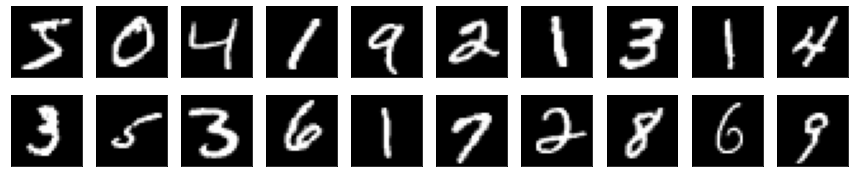

In [4]:
print(train_loader.dataset.train_labels.shape)
print(train_loader.dataset.train_data.shape)
input_dim = train_loader.dataset.train_data.shape[1]*train_loader.dataset.train_data.shape[2]
print("Input dimension is {}.".format(input_dim))
output_dim = 10

# Plot example images
fig=plt.figure(figsize=(15,3))
for image in range(20):
    show_img = train_loader.dataset.train_data[image].numpy().reshape(28, 28)
    fig.add_subplot(2,10,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(show_img, cmap='gray')
plt.show()

In [5]:
class Simple_RNN(nn.Module):
    def __init__(self, input_size, n_neurons, num_classes):
        super(Simple_RNN, self).__init__()
        self.input_size = input_size
        self.n_neurons = n_neurons
        self.num_classes = num_classes
        self.basic_rnn = nn.RNN(self.input_size, self.n_neurons, batch_first=True)
        self.fc = nn.Linear(self.n_neurons, self.num_classes)
    
    def forward(self, x):
        out, _ = self.basic_rnn(x)  
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return F.log_softmax(out, dim=1)

In [6]:
# This function trains the model for one epoch
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data[:,0].to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [7]:
# This function evaluates the model on the test data
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data[:,0].to(device)
            target = target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

In [8]:
# Main
t0 = time.time()

model = Simple_RNN(args.input_size, args.n_neurons, args.num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=args.lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader)
    
t1 = time.time() - t0
print(f'Training took {t1/60:.2f} minutes')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319116
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.365336
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.127164
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.981703
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.080786
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.963836
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.109584
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.140378
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.118328
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.133264

Test set: Average loss: 1.0635, Accuracy: 5988/10000 (59.88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.304999
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.998363
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.323484
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.184381
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.062440
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.286780
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.191850
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.267092
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.59769